In [2]:
import numpy as np
import pandas as pd
import math

import sys
sys.path.insert(0, "../")

#import DataGenerator

from qDenseCNN import qDenseCNN
from denseCNN import denseCNN

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('PDF')

In [8]:
from martinModels import models
import graphUtil
import numba

In [9]:
from plotWafer import plotWafer

In [10]:
from train import emd

In [11]:
def invertArrange(arrange):
    remap =[]
    hashmap = {}
    for i in range(len(arrange)):
        hashmap[arrange[i]]=i
    for i in range(len(arrange)):        
        remap.append(hashmap[i])
    return np.array(remap)

arrange443 = np.array([0,16, 32,
                       1,17, 33,
                       2,18, 34,
                       3,19, 35,
                       4,20, 36,
                       5,21, 37,
                       6,22, 38,
                       7,23, 39,
                       8,24, 40,
                       9,25, 41,
                       10,26, 42,
                       11,27, 43,
                       12,28, 44,
                       13,29, 45,
                       14,30, 46,
                       15,31, 47])
remap = invertArrange(arrange443)

In [126]:
@numba.jit
def unnormalize(norm_data,maxvals,rescaleOutputToMax=False):
    for i in range(len(norm_data)):
        if rescaleOutputToMax:
            norm_data[i] =  norm_data[i] * maxvals[i] / (norm_data[i].max() if norm_data[i].max() else 1.)
        else:
            norm_data[i] =  norm_data[i] * maxvals[i] / (norm_data[i].sum() if norm_data[i].sum() else 1.)
    return norm_data
@numba.jit
def normalize(data,rescaleInputToMax=False):
    maxes =[]
    sums =[]
    for i in range(len(data)):
        maxes.append( data[i].max() )
        sums.append( data[i].sum() )
        if rescaleInputToMax:
            data[i] = 1.*data[i]/(data[i].max() if data[i].max() else 1.)
        else:
            data[i] = 1.*data[i]/(data[i].sum() if data[i].sum() else 1.)
    return data,np.array(maxes),np.array(sums)

In [13]:
model_folder = '../V11/signal/nElinks_5/Sep1_CNN_keras_norm/'
model_name = model_folder.split('/')[-2]
f_model         = model_folder+'/'+model_name+".json"
f_encoder       = model_folder+'/'+"encoder_"+model_name+".json"
f_encoder_pkl   = model_folder+'/'+"encoder_"+model_name+".pkl"
f_encoder_pb    = model_folder+'/'+"encoder_"+model_name+".pb"
f_decoder       = model_folder+'/'+"decoder_"+model_name+".json"
verify_input    = model_folder+'verify_input.csv'
verify_output   = model_folder+'verify_output.csv'
vinput  = np.genfromtxt(verify_input, delimiter=',')
voutput = np.genfromtxt(verify_output, delimiter=',')

In [14]:
encoder       =  graphUtil.loadModel(f_encoder)
autoencoder   = graphUtil.loadModel(f_model)

In [153]:
f_raw = '../SampleSplitting_SignalAllocation/nElinks_5/ttbar_v11_eolNoise_Layer9_5Links.csv'
calQ     = np.genfromtxt(f_raw, delimiter=',',usecols=[*range(0, 48)],skip_header=2000,max_rows=10000)
sumQ     = calQ.sum(axis=1)
calQ     = calQ[sumQ>0]
sumQ     = sumQ[sumQ>0]

inputQf_48_arr   = np.array([calQ[i]/s for i,s in enumerate(sumQ)])[:,arrange443]  
inputQf_443_arr  = inputQf_48_arr.reshape(len(inputQf_48_arr),4,4,3)
inputQ_48_arr    = np.array([inputQf_48_arr[i]*s for i,s in enumerate(sumQ)])              
inputQ_443_arr   =  inputQ_48_arr.reshape(len(inputQ_48_arr),4,4,3) 
inputQ_48_calQ   =  inputQ_48_arr[:,remap] 
outputQf_443_arr  = autoencoder.predict(inputQf_443_arr)
outputQ_443_arr   = unnormalize(outputQf_443_arr,sumQ)
outputQ_48_calQ   = outputQ_443_arr.reshape(len(outputQ_443_arr),48)[:,remap]

emd_arr  = np.array(  [emd(inputQ_443_arr[i],outputQ_443_arr[i]) for i in range(0,len(inputQ_443_arr))])
emd_calQ = np.array(  [emd(inputQ_48_calQ[i],outputQ_48_calQ[i]) for i in range(0,len(calQ))] )               

In [ ]:
emd_calQ = np.array(  [emd(calQ[i]          ,outputQ_48_calQ[i]) for i in range(0,len(calQ))] )               

In [76]:
print('inputQ:',calQ[1])
print('ouputQ:',np.round(outputQ_48_calQ[1]))
print('inputQ sum =',calQ[1].sum())
print('ouputQ sum = ',outputQ_48_calQ[1].sum())

inputQ: [ 0.  0.  8.  0.  0.  0. 30.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
ouputQ: [ 0.  0.  3.  0.  2.  0. 23.  2.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.
  0.  1.  0.  3.  2.  0.  0.  1.  0.  0.  0.  0.]
inputQ sum = 50.0
ouputQ sum =  50.000008


In [194]:
plt.setlogy(1)
plt.hist(sumQ,50)

AttributeError: module 'matplotlib.pyplot' has no attribute 'setlogy'

In [189]:
len(calQ)

8932

In [186]:
## list high occ indices
occ = (np.count_nonzero(calQ>1,axis=1))
np.where(occ<5)[0][3726]

5000

In [178]:
max(emd_calQ[np.where(occ<5)[0]])

8.203823487156942

In [182]:
emd_calQ[np.where(occ<5)[0]][3726]

8.203823487156942

In [181]:
np.argmax(emd_calQ[np.where(occ<5)[0]])

3726

In [116]:
emd_calQ[97]

3.4249237417423166

In [117]:
np.quantile(emd_calQ,0.2)

1.059779950378112

In [118]:
np.quantile(emd_calQ,0.9)

3.2269536726734973

In [122]:
np.where(emd_calQ<np.quantile(emd_calQ,0.2))[0][1:10]

array([14, 16, 17, 22, 27, 30, 32, 33, 35])

In [121]:
np.where(emd_calQ>np.quantile(emd_calQ,0.9))[0][1:10]

array([19, 21, 23, 29, 43, 54, 66, 76, 84])

In [164]:
print(a*35)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   3.99 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   3.99 0.   0.   0.   0.   0.   0.   0.
 3.01 0.   0.   3.01 0.   0.  ]


In [103]:
i = 100
emd(inputQ_443_arr[i],outputQ_443_arr[i])

0.8437573511108429

Text(0.5, 0.98, 'EMD = 8.204, occ = 1, sumQ = 43.0')

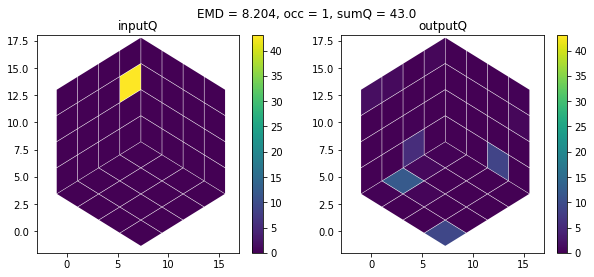

In [190]:
i = 5000

fig, axs = plt.subplots(1,2, figsize=(10, 4))
axs[0].set(title='inputQ')
axs[1].set(title='outputQ')
minQ = min(min(calQ[i]),min(outputQ_48_calQ[i]))
maxQ = max(max(calQ[i]),max(outputQ_48_calQ[i]))
plotWafer(calQ[i], fig, axs[0], scale=(minQ,maxQ))
plotWafer(outputQ_48_calQ[i], fig, axs[1], scale=(minQ,maxQ))
fig.suptitle('EMD = %.3f, occ = %s, sumQ = %s'%(emd_calQ[i],occ[i],sumQ[i]))

48